In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.cluster import KMeans 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
import pickle
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem.porter import PorterStemmer

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')


# email module has some useful functions
import os, sys, email,re

In [2]:
df = pd.read_csv('C:/Users/hsone/Desktop/Winter_2020/IRS/Project/Hardik_Project/Classification Models/classification_dataset.csv', encoding='ISO-8859-1')

In [3]:
df.head(2)

,File_Name,Content,Category
0,760760B1,integrating cots search engines into eclipse g...,icse
1,7CEB1A98,study on existence of cnt in nanocomposite cnt...,icse


In [4]:
df.head(2)

,File_Name,Content,Category
0,760760B1,integrating cots search engines into eclipse g...,icse
1,7CEB1A98,study on existence of cnt in nanocomposite cnt...,icse


In [5]:
#Downloading punkt and wordnet from NLTK
nltk.download('punkt')
print("------------------------------------------------------------")
nltk.download('wordnet')

------------------------------------------------------------


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hsone\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hsone\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
# Saving the lemmatizer into an object
wordnet_lemmatizer = WordNetLemmatizer()

In [7]:
nrows = len(df)
lemmatized_text_list = []

for row in range(0, nrows):
    
    # Create an empty list containing lemmatized words
    lemmatized_list = []
    
    # Save the text and its words into an object
    text = df.loc[row]['Content']
    text_words = text.split(" ")

    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        
    # Join the list
    lemmatized_text = " ".join(lemmatized_list)
    
    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)

In [8]:
df['Content_Parsed_5'] = lemmatized_text_list

In [9]:
# Downloading the stop words list
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hsone\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
# Loading the stop words in english
stop_words = list(stopwords.words('english'))

In [11]:
df['Content_Parsed_6'] = df['Content_Parsed_5']

for stop_word in stop_words:

    regex_stopword = r"\b" + stop_word + r"\b"
    df['Content_Parsed_6'] = df['Content_Parsed_6'].str.replace(regex_stopword, '')

In [12]:
list_columns = ["File_Name", "Category", "Content", "Content_Parsed_6"]
df = df[list_columns]

df = df.rename(columns={'Content_Parsed_6': 'Content_Parsed'})

In [13]:
category_codes = {
    'icse': 0,
    'vldb': 1
}

In [14]:
# Category mapping
df['Category_Code'] = df['Category']
df = df.replace({'Category_Code':category_codes})

In [15]:
df.head(2)

,File_Name,Category,Content,Content_Parsed,Category_Code
0,760760B1,icse,integrating cots search engines into eclipse g...,integrate cots search engines eclipse google ...,0
1,7CEB1A98,icse,study on existence of cnt in nanocomposite cnt...,study existence cnt nanocomposite cnt meh p...,0


In [16]:
df.shape

(8823, 5)

In [17]:
def create_corpus_df(text, target):
    corpus=[]
    
    for x in df[df['Category_Code']==target]['Content_Parsed'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [18]:
#Word Cloud for ICSE
corpus_new0=create_corpus_df(df,0)
len(corpus_new0)

32863

<Figure size 432x288 with 0 Axes>

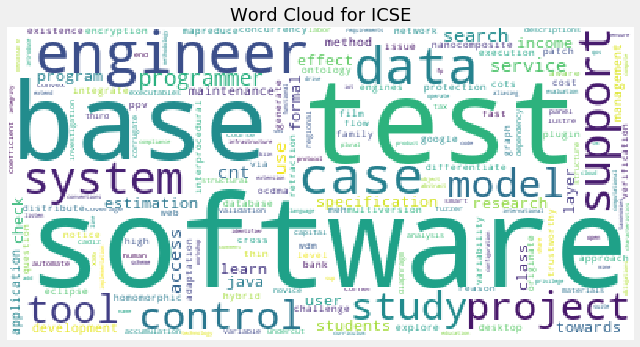

In [19]:
# Generating the wordcloud with the values under the category dataframe
plt.figure()
word_cloud = WordCloud(
                          background_color='white',
                          max_font_size = 80
                         ).generate(" ".join(corpus_new0[:300]))
plt.figure(figsize=(10,10))
plt.imshow(word_cloud)
plt.title('Word Cloud for ICSE',fontsize=18)
plt.axis('off')
plt.show()

In [20]:
#Word Cloud for VLDB
corpus_new1=create_corpus_df(df,1)
len(corpus_new1)

27718

<Figure size 432x288 with 0 Axes>

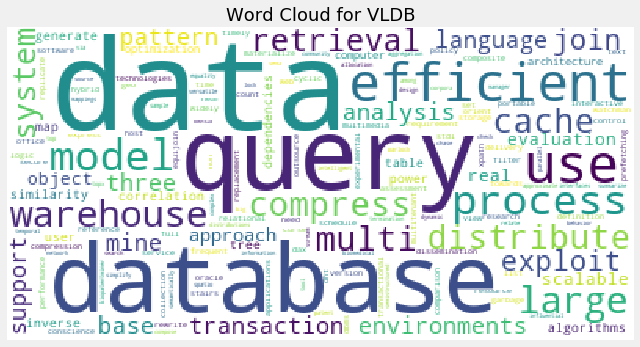

In [21]:
# Generating the wordcloud with the values under the category dataframe
plt.figure()
word_cloud = WordCloud(
                          background_color='white',
                          max_font_size = 80
                         ).generate(" ".join(corpus_new1[:300]))
plt.figure(figsize=(10,10))
plt.imshow(word_cloud)
plt.title('Word Cloud for VLDB',fontsize=18)
plt.axis('off')
plt.show()

In [22]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [23]:
stemmer = PorterStemmer()
def stemming_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [porter_stemmer.stem(word) for word in words]
    return words

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vectorizor = TfidfVectorizer(tokenizer = tokenize_and_stem, max_features = 5000)
tf_idf = tf_idf_vectorizor.fit_transform(df['Content_Parsed'])
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()
pd.DataFrame(tf_idf_array, columns=tf_idf_vectorizor.get_feature_names()).head()

,100mw,10b,10g,10ga0,10th,110nm,11a,11b,11g,11th,...,zhuzhou,zigbe,zigzag,zinc,zn,zncdse,zno,zone,zoo,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Wall time: 87.3 ms


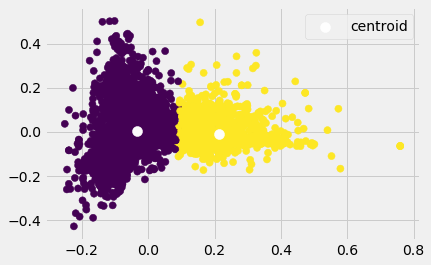

In [51]:
from sklearn.cluster import KMeans
n_clusters = 2
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
kmeans = KMeans(n_clusters= n_clusters, max_iter=600, algorithm = 'auto')
%time fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=prediction ,s=50, cmap='viridis')

centers2 = fitted.cluster_centers_
plt.scatter(centers2[:, 0], centers2[:, 1],c='white', s=100, label='centroid', alpha=0.99);
plt.legend()

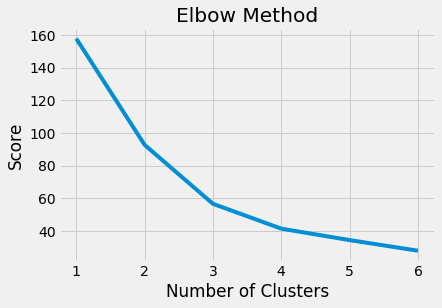

In [54]:
number_clusters = range(1, 7)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]
score = [i*-1 for i in score]

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

In [55]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_idf_vectorizor.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(tf_idf_array, prediction, 20)

C:\Users\hsone\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


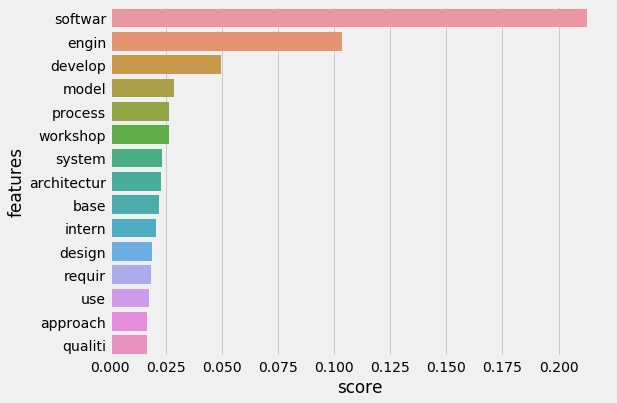

In [56]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[0][:15])

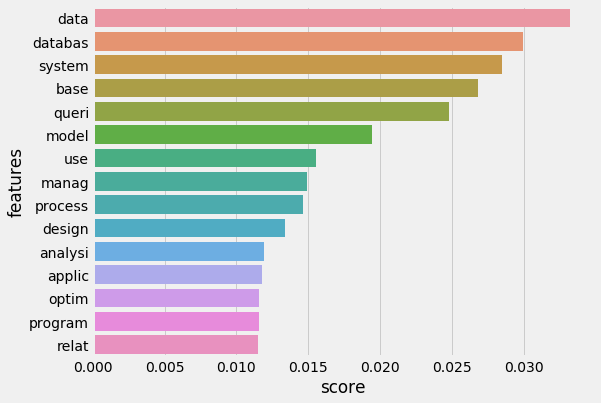

In [57]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[1][:15])

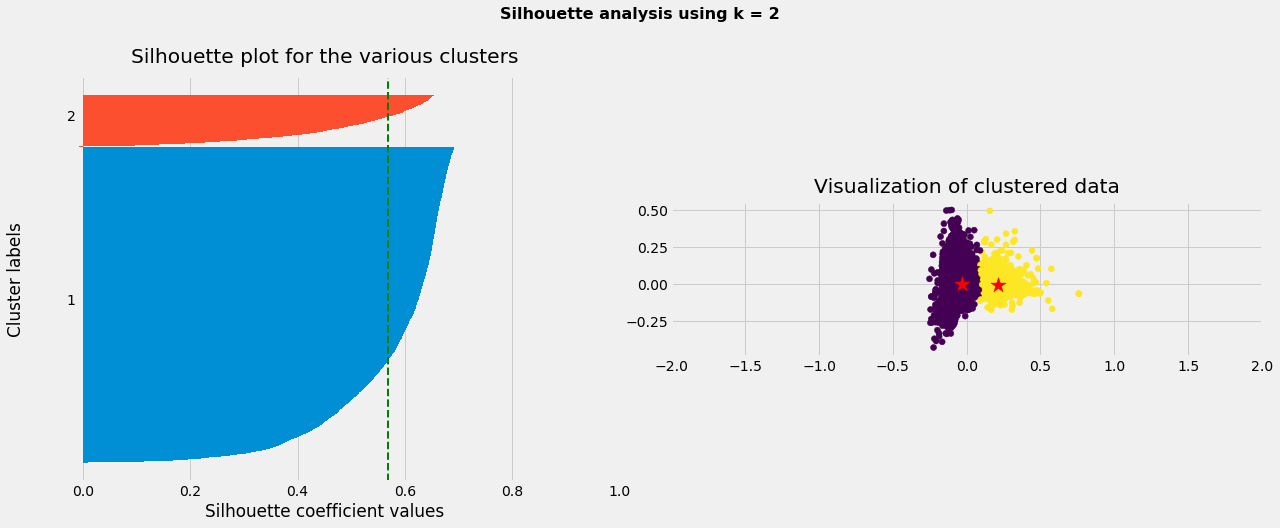

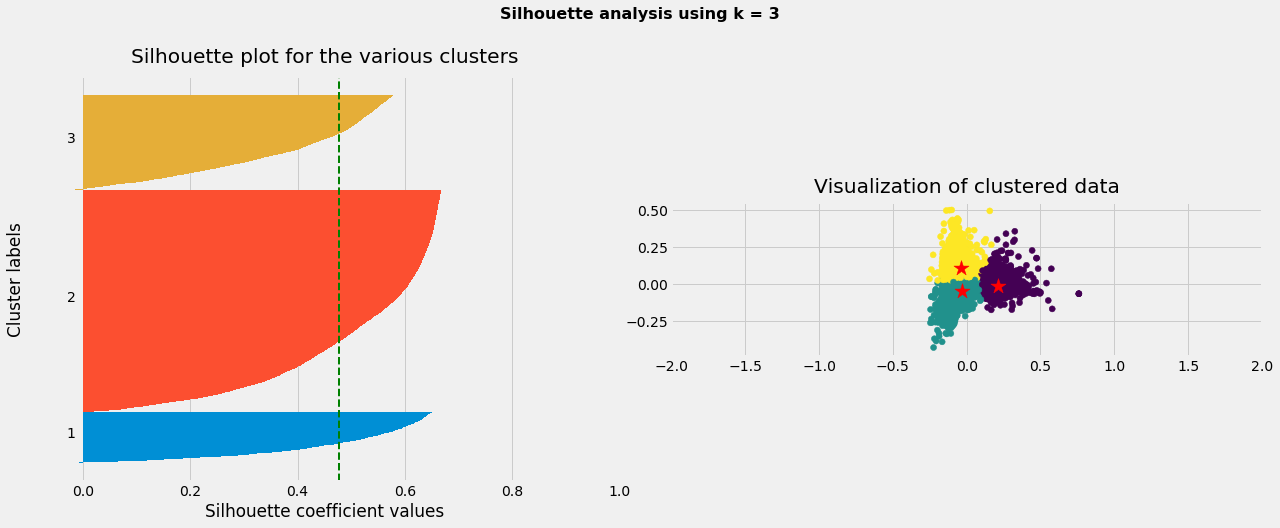

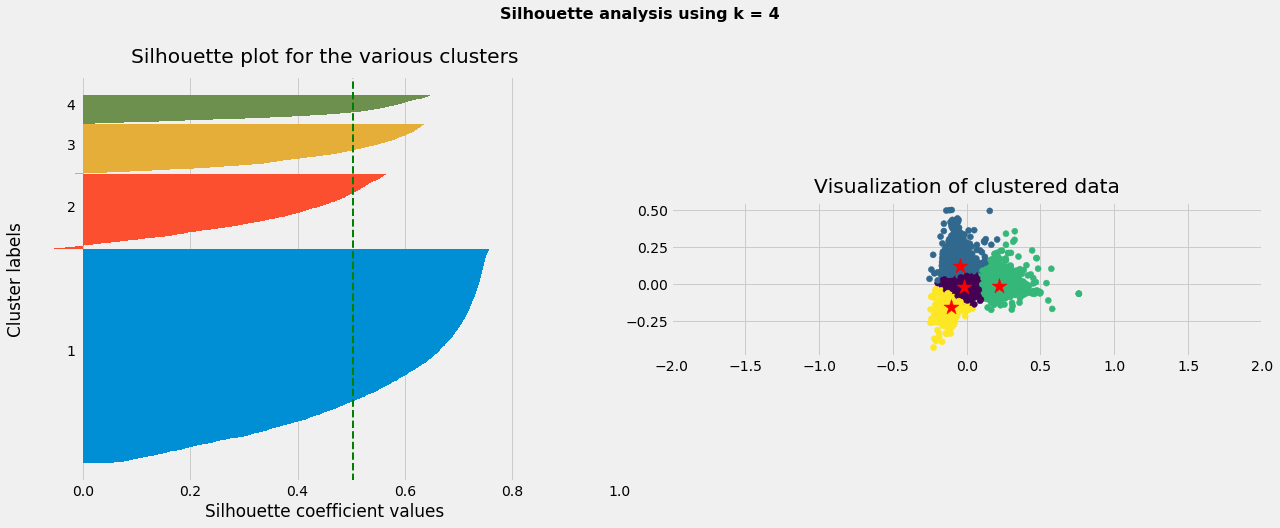

In [54]:
from sklearn.metrics import silhouette_samples, silhouette_score
for i, k in enumerate([2, 3, 4]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(Y_sklearn)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(Y_sklearn, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
    # Scatter plot of data colored with labels
    ax2.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=labels)
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.set_xlim([-2, 2])
    ax2.set_xlim([-2, 2])
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);

In [ ]:
https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a
    
https://www.kaggle.com/dfoly1/k-means-clustering-from-scratch